In [10]:
# Import Libraries
import os
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph.
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [11]:
# Loading data
df = pd.read_csv('Complaints.csv')
print(df.shape)

(142, 2)


In [12]:
df.head(3).T #Display First 3 lines

,0,1,2
Complaints,My bill seems higher than usual.,"I received a late payment notice, but I paid o...",Can you explain the charges on my recent bill?
Department,Billing,Billing,Billing


In [13]:
pd.DataFrame(df.Department.unique()).values #Get unique values in department column

array([['Billing'],
       ['Technical'],
       ['HR']], dtype=object)

In [14]:
# Create a new column 'department_id' with encoded Departments
df2 = df.sample(100, random_state=1).copy()
df2['department_id'] = df2['Department'].factorize()[0]
department_id_df = df2[['Department', 'department_id']].drop_duplicates()
# Dictionaries for future use
department_to_id = dict(department_id_df.values)
id_to_department = dict(department_id_df[['department_id', 'Department']].values)
# New dataframe
df2.head()

,Complaints,Department,department_id
78,TV screen is blank.,Technical,0
116,The customer service representative was not em...,HR,1
31,The billing statement does not match my usage.,Billing,2
5,The billing statement is unclear; I need clari...,Billing,2
125,The agent was unable to guide me through the p...,HR,1


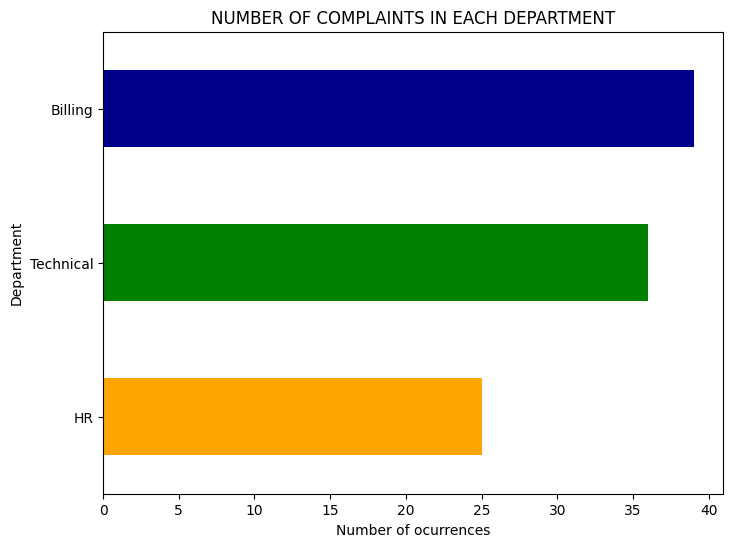

In [15]:
#Plot to see number of complaints in each department
ig = plt.figure(figsize=(8,6))
colors = ['orange','green','darkblue',]
df2.groupby('Department').Complaints.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF COMPLAINTS IN EACH DEPARTMENT')
plt.xlabel('Number of ocurrences', fontsize = 10);

In [16]:
X = df2['Complaints'] # Collection of documents
y = df2['Department'] # Labels we want to predict
#Splitting data into training and testing
#test_size=0.25 means 25% of data will be using for testing and 75% of data will be used to train the model
#random_state = 0 means, when the code is run multiple times, it will get the same split each time
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state = 0)

In [17]:
models = [
    SVC(kernel='linear', C=1),

]
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2),
                        stop_words='english')
features = tfidf.fit_transform(df2.Complaints).toarray()
labels = df2.department_id
# 3 Cross-validation
CV = 3
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
cv_df

,model_name,fold_idx,accuracy
0,SVC,0,0.911765
1,SVC,1,0.878788
2,SVC,2,0.939394


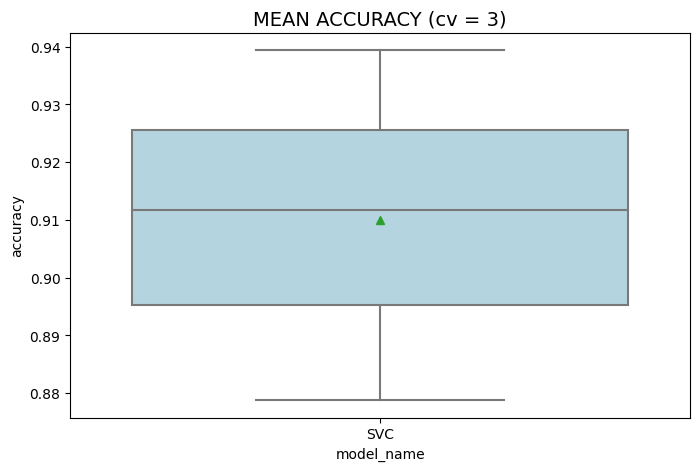

In [18]:
# Set up the plot with a specific figure size
plt.figure(figsize=(8, 5))

# Create a boxplot to visualize the distribution of accuracy scores for the single model
sns.boxplot(x='model_name', y='accuracy',
            data=cv_df,
            color='lightblue',  # Set the color of the boxes
            showmeans=True)    # Display the mean value as a diamond marker

# Add a title to the plot
plt.title("MEAN ACCURACY (cv = 3)", size=14)

# Display the plot
plt.show()


In [19]:
# Split the data into training and testing sets
# The third argument (df2.index) represents the indices of the original DataFrame
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features,
                                                                               labels,
                                                                               df2.index,
                                                                               test_size=0.25,
                                                                               random_state=1)

# Create a Random Forest Classifier with specific parameters
model = SVC(kernel='linear', C=1)

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)


In [20]:
# Classification report
print('CLASSIFICATIION METRICS')
print(metrics.classification_report(y_test, y_pred,
                                    target_names= df2['Department'].unique()))

CLASSIFICATIION METRICS
              precision    recall  f1-score   support

   Technical       0.78      1.00      0.88         7
          HR       1.00      1.00      1.00         6
     Billing       1.00      0.83      0.91        12

    accuracy                           0.92        25
   macro avg       0.93      0.94      0.93        25
weighted avg       0.94      0.92      0.92        25



In [21]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state=0)

# Create a TF-IDF vectorizer with specific parameters
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2),
                        stop_words='english')

# Fit the vectorizer on the training data
fitted_vectorizer = tfidf.fit(X_train)

# Transform the training data into TF-IDF vectors
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

# Create a Random Forest Classifier with specific parameters and fit it on the TF-IDF vectors and corresponding labels
model = SVC(kernel='linear', C=1).fit(tfidf_vectorizer_vectors, y_train)


In [22]:
complaint = """I need charges in my bill"""
print(model.predict(fitted_vectorizer.transform([complaint])))

['Billing']


In [23]:
complaint = """One of your agent was so rude to me"""
print(model.predict(fitted_vectorizer.transform([complaint])))

['HR']


In [24]:
complaint = """My data is not working and i can't send messages"""
print(model.predict(fitted_vectorizer.transform([complaint])))

['Technical']
